In [830]:
from dotenv import load_dotenv; load_dotenv()
import datetime as dt
from datetime import datetime
import requests_cache
import os
import pandas_datareader.data as web
import pandas as pd
import matplotlib
import requests
import bs4 as bs
import pickle

In [831]:
def get_prices(ticker, start, end):
    '''returns dataframe of adjusted close prices of specified ticker from start to end date'''
    start = datetime(start[0], start[1], start[2])
    end = datetime(end[0], end[1], end[2])
    api_key = os.getenv('ALPHAVANTAGE_API_KEY')
    session = requests_cache.CachedSession()

    prices = web.DataReader(ticker, 'av-daily-adjusted', start, end, api_key=api_key, session=session)
    prices = prices[['close']]
    prices.columns = [ticker]

    return prices

In [832]:
def get_all_prices(tickers, start, end):
    '''returns dataframe containing adjusted close prices of all specified tickers'''
    prices = []
    for ticker in tickers:
        try:
            prices.append(get_prices(ticker, start, end))
        except KeyError:
            pass
    return pd.concat(prices, axis=1)

In [833]:
def get_n_day_returns(prices, n=1):
    '''takes in prices df and n and returns n-day forward return df'''
    returns = (prices.shift(-n) / prices) - 1
    returns = returns[:-n]
    return returns

In [834]:
def get_signal_data(file_name, s, e):
    '''takes in file name, start, end dates as tuples and returns df containing signal data'''
    data = pd.read_csv(file_name, index_col='date')
    start = dt.datetime(s[0], s[1], s[2])
    end = dt.datetime(e[0], e[1], e[2])
    data.index = pd.to_datetime(data.index)
    data = data.loc[start:end]
    return data


In [835]:
def generate_rsi_data(prices, period=14):
    '''creates rsi df using price df given and specified period length'''
    # i think this is accurate?
    # look at tradingview implementation of rsi later
    data = prices.copy()
    data = data.diff()
    data = data[1:]
    up = data.copy()
    down = data.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(period).mean()
    roll_down = down.abs().rolling(period).mean()
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi.dropna()

In [836]:
def generate_quantiles(prices, n=5):
    '''puts each stock into quantile for each day based on signal score'''
    data = generate_rsi_data(prices)
    # try to refactor this, loops aren't good
    for i, x in enumerate(data.index):
        data.iloc[i] = pd.qcut(data.iloc[i], n, labels=[str(i + 1) for i in range(n)])
    return data

In [837]:
def generate_backtest(quantiles, returns, n=5):
    '''generates backtest data from quantiles and returns data'''
    data = quantiles.copy()
    data = data[:-1]
    quantiles = quantiles[:-1]
    data.columns = [i + 1 for i in range(n)]
    for date in quantiles.index:
        for ticker in quantiles.columns:
            quantile = int(quantiles.loc[date, ticker])
            data.loc[date, quantile] = returns.loc[date, ticker]
    data.index = pd.to_datetime(data.index)
    data = data + 1
    data = data.cumprod()
    data.plot()
    return data

In [838]:
def get_sp500_tickers():
    '''pulls list of sp500 tickers'''
    # sort of works, try to implement later
    tickers = []
    res = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(res.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)

    new_tickers = []
    for ticker in tickers:
        new_tickers.append(ticker.rstrip())
        
    return new_tickers

(               AAPL   JBLU    JPM    AMZN    TGT
 2015-01-05  106.250  15.22  60.55  302.19  73.98
 2015-01-06  106.260  14.97  58.98  295.29  73.97
 2015-01-07  107.750  15.10  59.07  298.42  76.77
 2015-01-08  111.890  14.88  60.39  300.46  77.13
 2015-01-09  112.010  14.38  59.34  296.93  76.43
 ...             ...    ...    ...     ...    ...
 2015-06-01  130.535  20.70  66.08  430.92  79.51
 2015-06-02  129.960  20.60  66.02  430.99  80.00
 2015-06-03  130.120  20.72  66.70  436.59  80.34
 2015-06-04  129.360  20.38  66.33  430.78  79.96
 2015-06-05  128.650  20.49  67.42  426.95  79.20
 
 [106 rows x 5 columns],
                    1         2         3         4         5
 2015-01-26  0.989959  0.993488  0.990603  0.990854  0.964987
 2015-01-27  0.964418  0.986844    1.0466   0.98168  0.936483
 2015-01-28  0.980624   1.00319   1.07371    1.0679  0.965638
 2015-01-29    0.9579  0.978206   1.22093   1.05227  0.945093
 2015-01-30  0.977101  0.986711   1.23625   1.04287  0.971591
 

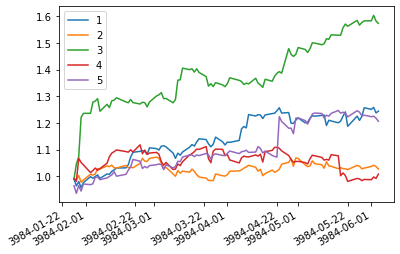

In [839]:
# testing stuff
tickers = ['AAPL', 'JBLU', 'JPM', 'AMZN', 'TGT']
start = (2015, 1, 5)
end = (2015, 6, 5)
quantiles = 5
prices = get_all_prices(tickers, start, end)
returns = get_n_day_returns(prices)
quantiles = generate_quantiles(prices, 5)
prices, generate_backtest(quantiles, returns, 5), quantiles, returns